#Predicting Covid-19 Cases Using RNN GRU Model

This use-case provides a demo of how RNN and GRU can be used to model time series data. In our use-case, we will use Covid-19 data to predict the number of future cases based on the available historical data. 

Workflow:


1.   Understanding the problem
2.   Collecting the data
3.   Data preprocessing
4.   Build Model using RNN & Grated Recurrent Unit (GRU)
5.   Training the dataset
6.   Predict 


##1. Understanding the problem
You have been given a dataset that has data of cases related to the spread of Covid-19 virus in India. We have to model the time series data using RNN GRU sequential model. 

###Import the necessary libraries

We will use keras for this purpose. Please load the following packages before you proceed further.

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
import datetime as dt


from keras.layers.core import Dense, Dropout
from keras.layers.recurrent import GRU
from keras.models import Sequential, load_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


##2. Collecting the Data
The dataset covid19.csv will be used for the demo. The dataset has the covid-19 cases recorded in India. It has been downloaded from the site https://www.kaggle.com/imdevskp/covid19-corona-virus-india-dataset 

The dataset has been modified to just keep 2 columns that are relevant to our analysis. It contains 2 fields and 89 rows:

The 5 columns in the dataset are:

1.   Date - Date of the cases starting from 31-Jan-2020. 
2.   Cases - Number of cases registered.


Please note that the availablity of data is scarse. 

Load the dataset using pandas read_csv function.

In [0]:
main_dataset = pd.read_csv("covid.csv") #Read the data

In [0]:
main_dataset

,Date,Cases
0,1/31/2020,0
1,2/1/2020,1
2,2/2/2020,1
3,2/3/2020,0
4,2/4/2020,0
...,...,...
84,4/24/2020,1684
85,4/25/2020,1429
86,4/26/2020,1586
87,4/27/2020,1568


###Trend

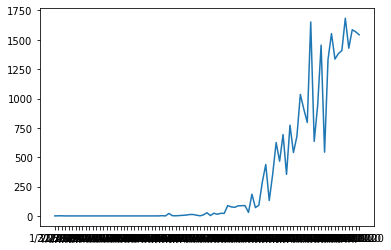

In [0]:
plt.plot(main_dataset.Date,main_dataset.Cases)
plt.show()

##3. Data Preprocessing

We use following steps to preprocess the available dataset.



1.   Create new features from the available variables
2.   Create target and predictor datasets
3.   Scale the values in the datasets
4.   Get the datasets into desired format and shape.
5.   Split the dataset into train & test with appropriate ratio.



In [0]:
dataset = main_dataset #Create another dataset same as the main dataset. Just to avoid replacing the main one. 
dataset = dataset.set_index('Date') #Set the index of the dataset as the date
dataset = dataset['Cases'] #We will be left with only one column Cases for our dataset

Create a new variable called Moving Average. Moving Average is a calculation of averages of subsequent datapoints. Example:





> 1-Jan-2010   100


> 2-Jan-2010   200







Moving average will be (200+100)/2 = 150

We will take moving average for 3 days in our example.

Note: You can create any number of such variables and any days.

In [0]:
dataset=dataset.to_frame() #Convert the Series into a dataframe object
dataset['Cases_MA2']=dataset.expanding(min_periods=3).mean()  #min_periods is used to set the no. of periods for calculating MA. Mean is for calculating average. 

Create a new variable called Exponential Moving Average(EMA). EMA gives more weightage to the recent values rather than the old values. This could be handy in time series forecasting techniques. 

We will take exponential moving average for 3 days in our example.

Note: You can create any number of such variables and any days.

In [0]:
dataset['EMA'] = dataset.iloc[:,0].ewm(span=3,adjust=False).mean() #ewm is used exponential moving average

In [0]:
dataset = dataset[dataset['Cases_MA2'].notna()] #Remove the rows that have NAs

Let's look at the dataset

In [0]:
dataset.head()

,Cases,Cases_MA2,EMA
Date,,,
2/2/2020,1,0.666667,0.750000
2/3/2020,0,0.500000,0.375000
2/4/2020,0,0.400000,0.187500
2/5/2020,0,0.333333,0.093750
2/6/2020,0,0.285714,0.046875


Here we will be predicting the column 'Cases'. Hence the target variable will be 'Cases'

In [0]:
#Cases is the column we have to predict. 
target=dataset[['Cases']]
del dataset['Cases']

Adjust the shapes of predictor and target sets. For this, we remove the last row of both the datasets.

In [0]:
dataset.drop(dataset.index[len(dataset)-1], axis=0, inplace=True) #Drop the last row in dataset
target.drop(target.index[len(target)-1], axis=0, inplace=True) #Drop the last row in target

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Convert both dataset and target into numpy arrays.


*   x -> dataset with predictor variables
*   y -> dataset with target variable




In [0]:
x, y = dataset.values, target.values

We now scale the values for the model.

In [0]:
x_scaled_set = MinMaxScaler() #Use MinMaxScaler function from sklearn.preprocessing library 
y_scaled_set = MinMaxScaler()

X = x_scaled_set.fit_transform(x) #Fit to data and transform the data array x
Y = y_scaled_set.fit_transform(y.reshape(-1,1)) #Fit to data and transform the data array y. Reshape the y variable to long format

Split the X into train and test datasets.

Consider Training data as first 77 rows of the data and next 8 rows will be used for testing the model. 

In [0]:
X_train_data=X[0:77,]
y_train_data=Y[0:77,]
X_test_data=X[78:86,]
y_test_data=Y[78:86,]

In [0]:
X_train_data = X_train_data.reshape((-1,1,2)) #Reshape train dataset to required format
X_test_data = X_test_data.reshape((-1,1,2)) #Reshape test dataset to required format

## 4. Build Model using RNN & Grated Recurrent Unit (GRU)

We will use the Sequential class from keras.models library to define a linear stack of network layers. These form a model. 

Using the add method, the necessary layers would be added to the model.

RNNs have an issue of short-term memory which means if the sequence is long, they tend to leave leave out the earlier ones and only retain information related to the later ones. To remove this problem, GRUs are used. In a way, GRU helps in keeping only the important information in the whole sequence. Initially, we add the GRU layer with necessary parameters. 

Then, we add a Dropout layer to prevent overfitting of the model.

We add another set of GRU and Dropout layers.

Post which we add a Dense layer which gives us the fully connected layer. We use the regular sigmoid activation function.

In our model, we will use Adam optimizer and consider mean square error as our loss function since ours is a Regression model. 

In [0]:
GRU_model = Sequential() #Use Sequential function from keras.model library
GRU_model.add(GRU(units=512,
              return_sequences=True,
              input_shape=(1, 2))) #Add GRU model with 512 units. Note that return sequences should be true to pass on the sequences. Ensure that input_shape is inline with the inout data. 
GRU_model.add(Dropout(0.2)) #Add a dropout layer to avoid overfitting.
GRU_model.add(GRU(units=256)) #Add another GRU layer with 256 units. 
GRU_model.add(Dropout(0.2)) #Add another dropout layer to avoid overfitting. 
GRU_model.add(Dense(1, activation='sigmoid')) #Finally, add a dense layer for getting a fully connected layer. 
GRU_model.compile(loss='mse', optimizer='adam') #mse is mean square error which is the loss function and Adam optimizer will be the ooptimizer. 

## 5. Training the Dataset

Fit the model by passing the training data we created earlier along with relevant batch size, epochs, validation split. 

Batch Size - The batch size controls the number of training samples before the model's internal parameters are updated

Epochs - How many times the whole training dataset be passed through the network. 


In [0]:
GRU_model.fit(X_train_data,y_train_data,batch_size=250, epochs=500, validation_split=0.15, verbose=1) 
#GRU_model.save("covid_GRU.h5") #Save the model if you want for reuse. 

Train on 65 samples, validate on 12 samples
Epoch 1/500
65/65 [==============================] - 1s 20ms/step - loss: 0.2216 - val_loss: 0.0471
Epoch 2/500
65/65 [==============================] - 0s 912us/step - loss: 0.2185 - val_loss: 0.0483
Epoch 3/500
65/65 [==============================] - 0s 809us/step - loss: 0.2147 - val_loss: 0.0498
Epoch 4/500
65/65 [==============================] - 0s 813us/step - loss: 0.2103 - val_loss: 0.0516
Epoch 5/500
65/65 [==============================] - 0s 902us/step - loss: 0.2050 - val_loss: 0.0539
Epoch 6/500
65/65 [==============================] - 0s 882us/step - loss: 0.1987 - val_loss: 0.0568
Epoch 7/500
65/65 [==============================] - 0s 886us/step - loss: 0.1914 - val_loss: 0.0608
Epoch 8/500
65/65 [==============================] - 0s 901us/step - loss: 0.1830 - val_loss: 0.0659
Epoch 9/500
65/65 [==============================] - 0s 1ms/step - loss: 0.1737 - val_loss: 0.0726
Epoch 10/500
65/65 [==============================

## 6. Predict

Use evaluate function to get the loss metric. Apply the created model on test dataset. 

Plot the predicted and actual values on a graph. 

The lower the 'score' metric (ie mean square error), better is our model.

In [0]:
score = GRU_model.evaluate(X_test_data, y_test_data) #Evaluate model can be used to get the loss metric. 
print('Score: {}'.format(score)) 
y_pred = GRU_model.predict(X_test_data) #Apply the built model on test data. 
y_test_pred = y_scaled_set.inverse_transform(y_pred) #Use inverse transform to undo the scaling that was done before. This gives us the original values. 
y_test_actual = y_scaled_set.inverse_transform(y_test_data) # Apply the inverse transform on the actual dataset for easy comparison of predicted vs actual. 
#plt.plot(y_test_pred[-100:], label='Predicted') #Plot the predicted vs actual graph
#plt.plot(y_test_actual[-100:], label='Actual')
#plt.legend()
#plt.show()

8/8 [==============================] - 0s 836us/step
Score: 0.008042370900511742


In [0]:
test_Dates=main_dataset.Date[80:88] #create an object which has the dates for the Test data. 

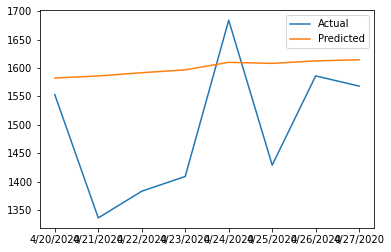

In [0]:
plt.plot(test_Dates,y_test_actual[-100:], label='Actual')
plt.plot(test_Dates,y_test_pred[-100:],label='Predicted')
plt.legend()
plt.show()



The mean square error (metric) is nearing zero. Analyzing the above graph, we see that our model was closely predicting for the 1st day. Though there are dip in cases after 20th April, our model predicted around 1600 cases. The cases saw a sudden spike which our model was able to predict very closely and maintained the trend till 27-April.

## Ending Notes

Please note the following very important points.



1.   We are dealing with a real-life scenario which we haven't seen before and hence, there can be room for lot of improvement. Given the scracity of the data available, sudden spikes and sudden dips are even more difficult to predict as the time series models show a constant trend while predicting. This is a very simple attempt in explaining GRU model for predicting time-series models. 
2.   Next steps would be change the moving average and exponential moving average to different spans and check how is the accuracy. Is our model doing any better?
3. Try changing the parameters of our GRU model and see if the model is performing better. 

